<a href="https://www.kaggle.com/code/fummicc1/fummicc1-cassava?scriptVersionId=115383373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Data

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import pandas as pd
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, List, Tuple
from tqdm import tqdm
import pandas as pd

In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

timm.list_models("efficient*", pretrained=True)

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

In [3]:
def class2dict(f) -> Dict:
    ans = dict()
    for name in dir(f):
        if name.startswith("__"):
            continue
        if not _is_primitive(getattr(f, name)):
            ans[name] = class2dict(getattr(f, name))
        else:
            ans[name] = getattr(f, name)
    return ans


def _is_primitive(value) -> bool:
    primitive = (int, str, bool, float, List, Dict)
    return type(value) in primitive

## Config

In [4]:
class Config:    
    batch_size = 64
    num_workers = 8
    n_epochs = 15
    lr = 1e-5
    model_name = "vit_large_patch16_224"
    is_kaggle_notebook = True
    
    base_input_path_for_kaggle = "/kaggle/input/cassava-leaf-disease-classification"
    base_input_path_for_local = "./"
    
    @property
    def base_input_path(self):
        return self.base_input_path_for_kaggle if self.is_kaggle_notebook else self.base_input_path_for_local

In [5]:
config = Config()
config.n_epochs = 10
config.batch_size = 16
config.num_workers = 2
config.lr = 5e-5
config.model_name = "efficientnet_b4"
config.is_kaggle_notebook = True

config.base_input_path

'/kaggle/input/cassava-leaf-disease-classification'

<AxesSubplot:>

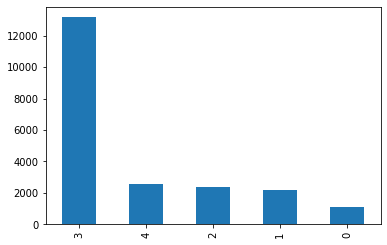

In [6]:
train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
train_df = pd.read_csv(train_path)
train_df.label.value_counts().plot(kind="bar")

In [7]:
from typing import Optional
from torch.utils.data import Dataset
import torch.nn as nn
from torchvision.transforms import transforms

class CassavaDataset(Dataset):
    def __init__(self, annotation_path: Optional[str], img_dir_path: str, img_transforms: transforms.Compose):
        self.has_label = annotation_path is not None
        if annotation_path:
            self.annotation_path = annotation_path
            self.annotation_data = pd.read_csv(annotation_path)
        else:
            self.annotation_path = None
            self.annotation_data = pd.DataFrame()
            self.annotation_data["image_id"] = list(os.listdir(img_dir_path))
        self.img_dir_path = img_dir_path
        self.img_transforms = img_transforms
        
    def __len__(self) -> int:
        return len(self.annotation_data)
    
    def __getitem__(self, index: int):
        data = self.annotation_data.iloc[index, :]
        image_id = data["image_id"]
        if self.has_label:
            label = data["label"]
        image_path = os.path.join(self.img_dir_path, image_id)        
        img = Image.open(image_path).convert("RGB")
        if self.img_transforms:
            img = self.img_transforms(img)
        if self.has_label:
            label = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=5)
            label = torch.squeeze(label, dim=0).float()
        if self.has_label:
            return img, image_id, label
        else:
            return img, image_id

## Network

In [8]:
import timm


class CassavaNetwork(nn.Module):
    def __init__(self, config: Config, output_dim: int = 5):
        super().__init__()
        self.base_model = timm.create_model(
            config.model_name,
            pretrained=not config.is_kaggle_notebook,
            num_classes=output_dim,
        )
    
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        return self.base_model(img)
    

model = CassavaNetwork(config=config)

## Trainer

In [9]:
import numpy as np
from typing import Optional
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp.autocast_mode import autocast
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch

from tqdm import tqdm
import sys
import os


class TrainerOutput:
    loss: float

    def __init__(self, loss: float):
        self.loss = loss

    @property
    def score(self) -> float:
        return self.loss


class Trainer:
    model: nn.Module
    config: Config
    optimizer: optim.Optimizer
    lr_scheduler: optim.lr_scheduler._LRScheduler
    loss_function: nn.CrossEntropyLoss
    dataloader: DataLoader
    scaler: Optional[GradScaler]

    def __init__(
        self,
        model: nn.Module,
        config: Config,
        optimizer: optim.Optimizer,
        lr_scheduler: optim.lr_scheduler._LRScheduler,
        loss_function: nn.CrossEntropyLoss,
        dataloader: DataLoader,
        scaler: Optional[GradScaler] = None,
    ):
        self.model = model
        self.config = config
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.scaler = scaler

    def advance(self, verbose: bool = False) -> TrainerOutput:
        scaler = None
        if self.scaler:
            scaler = self.scaler
        self.model = self.model.train()
        GPU_DEVICE = torch.device("cuda")
        epoch_loss = 0
        with autocast(enabled=True):
            with torch.enable_grad():
                for batch in tqdm(self.dataloader):
                    if len(batch) == 3:
                        imgs, ids, labels = batch
                    elif len(batch) == 2:
                        imgs, labels = batch
                    else:
                        continue
                    self.optimizer.zero_grad()
                    imgs = imgs.to(GPU_DEVICE)
                    labels = labels.to(GPU_DEVICE)
                    out: torch.Tensor = self.model(imgs)
                    out = out.float()
                    if verbose:
                        print("out-shape", out.shape)
                        print("out", out)                        
                    if verbose:
                        print("labels", labels)
                    loss = self.loss_function(out, labels)
                    if verbose:
                        print("loss", loss)
                    if scaler is not None:
                        scaler.scale(loss).backward()
                    else:
                        loss.backward()
                    epoch_loss += loss.item()
                    if scaler is not None:
                        scaler.step(self.optimizer)
                        scaler.update()
                    else:
                        self.optimizer.step()
                self.lr_scheduler.step()
        loss = epoch_loss / (len(self.dataloader))
        return TrainerOutput(loss=loss)
    
    def save_model(self):
        config = self.config
        out_path = os.path.join("./", "weights")
        os.makedirs(out_path, exist_ok=True)
        out_path = os.path.join(out_path, f"epoch_{config.n_epochs}_base_{config.model_name}.pth")
        torch.save(self.model.state_dict(), out_path)

## Classifier

In [10]:
from typing import Callable, Dict, List, Tuple, Union, Optional
from typing_extensions import Self
import numpy as np
from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import sys
import os
import pandas as pd
from tqdm import tqdm

class ClassifierOutput:
    move_to_full_nn_img_ids: List[str]
    count: int
    acc: float
    loss: float
    df: pd.DataFrame

    def __init__(
        self,
        count: int,
        acc: float,
        loss: float,
        df: pd.DataFrame = pd.DataFrame()
    ):
        self.count = count        
        self.acc = acc
        self.loss = loss
        self.df = df

    @property
    def score(self) -> float:
        return self.acc


class ClassifierTrainInput:
    def __init__(self):
        pass

class ClassifierTestInput:
    def __init__(self):
        pass

class Classifier:

    model: nn.Module
    activate_function: nn.Softmax
    loss_function: Optional[nn.CrossEntropyLoss]
    c_high: float
    c_low: float
    dataloader: DataLoader
    phase: str
    phase_input: Union[ClassifierTrainInput, ClassifierTestInput]
    on_classify: Optional[Callable]

    def __init__(
        self,
        model: nn.Module,
        activate_function: nn.Softmax,
        dataloader: DataLoader,
        phase: str,
        phase_input: Union[ClassifierTrainInput, ClassifierTestInput],
        loss_function: Optional[nn.CrossEntropyLoss] = None,
        on_classify: Optional[Callable] = None,
    ):
        self.model = model
        self.activate_function = activate_function
        self.loss_function = loss_function
        self.dataloader = dataloader
        self.phase = phase
        self.phase_input = phase_input
        self.on_classify = on_classify

    def infer(
        self, verbose: bool = False, handle_all: bool = False, calc_acc: bool = True
    ) -> ClassifierOutput:
        net = self.model
        loader = self.dataloader
        loss_function = self.loss_function
        count = 0
        correct = 0        
        GPU_DEVICE = torch.device("cuda")
        called = False
        net = net.eval()
        epoch_loss = 0
        label_df = pd.DataFrame()
        with torch.no_grad():
            for batch in tqdm(loader):
                if len(batch) == 3:
                    imgs, ids, labels = batch
                elif len(batch) == 2:
                    imgs, ids = batch
                    labels = None
                else:
                    continue
                imgs = imgs.to(GPU_DEVICE)
                if labels is not None:
                    labels = labels.to(GPU_DEVICE)                
                outputs = net(imgs)
                if loss_function and labels is not None:
                    loss = loss_function(outputs, labels)
                    epoch_loss += loss.item()
                outputs = self.activate_function(outputs)
                if verbose:
                    print("output", outputs[:10])
                _, pred_indexes = torch.max(outputs, dim=1)
                pred_indexes: Tensor = pred_indexes
                if verbose:
                    print(f"{self.phase}_predicted_indexes", pred_indexes)
                    print(f"{self.phase}_labels", labels)
                if not called and self.on_classify is not None:
                    if not handle_all:
                        called = True
                    self.on_classify(imgs, pred_indexes)
                
                if labels is not None:
                    labels = torch.tensor(list(map(lambda nums: (nums==1).nonzero().item(), labels))).to(GPU_DEVICE)
                count += pred_indexes.shape[0]
                batch_df = pd.DataFrame()
                batch_df["image_id"] = ids
                batch_df["label"] = pd.Series(pred_indexes.detach().cpu().numpy())
                if len(label_df) == 0:
                    label_df = batch_df
                else:
                    label_df = pd.concat([label_df, batch_df])              
                if labels is not None and calc_acc:
                    correct += int(torch.where(pred_indexes == labels, 1.0, 0.0).sum())                    
            acc = correct / count
            epoch_loss = epoch_loss / (len(loader))
            label_df.reset_index(drop=True, inplace=True)
            ret = ClassifierOutput(
                count=count,
                acc=acc,
                loss=epoch_loss,
                df=label_df
            )            
            return ret

## Run

<AxesSubplot:>

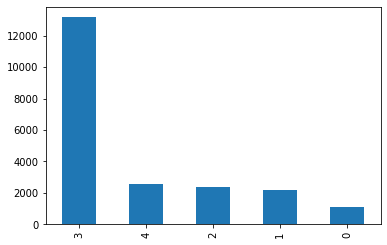

In [11]:
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset

index = 3
name = f"run-{index}"
notes = ""

train_path = os.path.join(config.base_input_path, "train.csv")
train_img_dir_path = os.path.join(config.base_input_path, "train_images")
df = pd.read_csv(train_path)

df.label.value_counts().plot(kind="bar")

In [12]:
import numpy as np
import torch
import os

def set_seed(seed):
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)
    return random_state

set_seed(42)

RandomState(MT19937) at 0x7F57C7833E20

In [13]:
k_fold = KFold(n_splits=2)
train_dataset = CassavaDataset(
    annotation_path=train_path,
    img_dir_path=train_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),    
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)
val_dataset = CassavaDataset(
    annotation_path=train_path,
    img_dir_path=train_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
    ]),
)

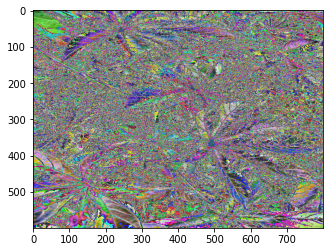

In [14]:
import matplotlib.pyplot as plt

img = train_dataset[10][0]
plt.imshow(transforms.ToPILImage()(img))

In [15]:
from torch.cuda.amp.grad_scaler import GradScaler

model = CassavaNetwork(config=config)
model = model.to(torch.device("cuda"))
model = nn.DataParallel(model)

if config.is_kaggle_notebook:
    pretrained_weight_path = "/kaggle/input/weights/epoch_10_base_efficientnet_b4.pth"
    model.load_state_dict(torch.load(pretrained_weight_path))
else:
    for fold, (train_index, val_index) in enumerate(k_fold.split(df)):
        train_subset = Subset(train_dataset, train_index)
        train_dataloader = DataLoader(
            train_subset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            shuffle=True,
        )
        val_subset = Subset(val_dataset, val_index)
        val_dataloader = DataLoader(
            val_subset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            shuffle=False,
        )    

        optimizer = optim.Adam(model.parameters(), lr=config.lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        loss_function = nn.CrossEntropyLoss()

        activate_function = nn.Softmax(dim=1)

        scaler = GradScaler()

        trainer = Trainer(
            model,
            config,
            optimizer,
            scheduler,
            loss_function,
            train_dataloader,
            scaler=scaler,
        )
        classifier = Classifier(
            model,
            activate_function,
            train_dataloader,
            phase="train",
            phase_input=ClassifierTrainInput(),
        )

        val_classifier = Classifier(
            model,
            activate_function,
            val_dataloader,
            phase="test",
            phase_input=ClassifierTestInput(),
        )

        for epoch in tqdm(range(config.n_epochs)):
            epoch += 1
            train_out = trainer.advance()
            print(f"epoch: {epoch}, train loss: {train_out.loss}")
            # train_infer_out = classifier.infer()
            # print(f"epoch: {epoch}, train acc: {train_infer_out.acc}")
            val_infer_out = val_classifier.infer()
            print(f"epoch: {epoch}, val acc: {val_infer_out.acc}")
            if epoch == config.n_epochs:
                trainer.save_model()


## Submission

In [16]:
test_data_img_dir_path = os.path.join(config.base_input_path, "test_images")
test_dataset = CassavaDataset(
    annotation_path=None,
    img_dir_path=test_data_img_dir_path,
    img_transforms=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize((224, 224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
)

activate_function = nn.Softmax(dim=1)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
)

test_classifier = Classifier(
    model,
    activate_function,
    test_dataloader,
    phase="test",
    phase_input=ClassifierTrainInput(),
)

out = test_classifier.infer(calc_acc=False, verbose=True)
out.df.to_csv("submission.csv", index=False)

100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

output tensor([[0.0127, 0.0392, 0.4759, 0.0320, 0.4402]], device='cuda:0')
test_predicted_indexes tensor([2], device='cuda:0')
test_labels None
